In [1]:
import warnings
import logging
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

DATA_SOURCE_DIR = '/kaggle/input/hw2-dataset'
DATA_SOURCE = os.path.join(DATA_SOURCE_DIR, 'mars_augmented.npz')

SEED = 12

np.random.seed(SEED)
random.seed(SEED)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from keras.saving import register_keras_serializable
from keras import layers as tfkl
from keras.layers import Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Multiply, Concatenate, UpSampling2D, MaxPooling2D, Input, Dense, Conv2DTranspose, DepthwiseConv2D

# Set seed for TensorFlowimage
tf.random.set_seed(SEED)
tf.compat.v1.set_random_seed(SEED)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

2.16.1


# Data

In [2]:
data = np.load(DATA_SOURCE)
print("Keys: ", data.keys())
train_valid_data = np.concatenate((
    data['cutmix_set'],
    data['ftr_set'],
    data['color_set'],
    data['big_rock_set']
), axis=0)
test_data = data['test_set']
print(train_valid_data.shape)
print(train_valid_data.dtype)
print(test_data.shape)
print(test_data.dtype)

Keys:  KeysView(NpzFile '/kaggle/input/hw2-dataset/mars_augmented.npz' with keys: cutmix_set, ftr_set, color_set, big_rock_set, test_set)
(8235, 2, 64, 128, 1)
float64
(10022, 64, 128, 1)
float64


In [3]:
def split(data, target=None, ratio=0.2, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)
    np.random.seed(seed)
    size = len(data)
    indices = np.arange(size)
    indices = np.random.permutation(indices)
    split = int(size * (1 - ratio))
    if target is None:
        return data[indices[:split]], data[indices[split:]]
    return data[indices[:split]], target[indices[:split]], data[indices[split:]], target[indices[split:]]

In [4]:
train_data, valid_data = split(train_valid_data, ratio=0.2, seed=SEED)

img_train = train_data[:, 0, :, :]
msk_train = train_data[:, 1, :, :]

img_valid = valid_data[:, 0, :, :]
msk_valid = valid_data[:, 1, :, :]

img_test = test_data

DATA_SHAPE = img_train.shape[1:]
NUM_CLASSES = len(np.unique(msk_train))
print(DATA_SHAPE)
print(NUM_CLASSES)

print(f"IMG: {img_train.shape}, {img_train.dtype}\n{img_train[0][0][:3]}")
print(f"MSK: {msk_train.shape}, {msk_train.dtype}\n{msk_train[0][0][:3]}")

(64, 128, 1)
5
IMG: (6588, 64, 128, 1), float64
[[0.44642651]
 [0.4399206 ]
 [0.42072761]]
MSK: (6588, 64, 128, 1), float64
[[2.]
 [2.]
 [2.]]


## Visual things

In [5]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        labels_np = labels_np[..., np.newaxis]
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j])
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Losses

In [6]:
@register_keras_serializable()
class CustomDiceLoss(tfk.losses.Loss):
    def __init__(self, labels_to_exclude=[0], name="custom_dice_loss", smooth=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.labels_to_exclude = labels_to_exclude
        self.smooth = smooth or 1.

    def call(self, y_true, y_pred):        
        y_true = tf.one_hot(tf.cast(y_true, tf.uint8), depth=tf.shape(y_pred)[-1])
        # Both are one-hot encoded at this point
        y_true_flat = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
        y_pred_flat = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
        
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true_flat, label)
            y_true_flat = tf.boolean_mask(y_true_flat, mask)
            y_pred_flat = tf.boolean_mask(y_pred_flat, mask)
        
        intersection = tf.math.reduce_sum(y_true_flat * y_pred_flat, axis=0)
        total = tf.math.reduce_sum(y_true_flat, axis=0) + tf.math.reduce_sum(y_pred_flat, axis=0)

        dice = (2. + intersection + self.smooth) / (total + self.smooth)

        # Return the Dice loss
        return 1. - tf.reduce_mean(dice)

In [ ]:
@register_keras_serializable()
class CustomFocalTverskyLoss(tfk.losses.Loss):
    def __init__(self, labels_to_exclude=[0], name="custom_focal_tversky_loss", smooth=None, alpha=None, gamma=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.labels_to_exclude = labels_to_exclude
        self.alpha = alpha or 0.5
        self.gamma = gamma or 1.
        self.smooth = smooth or 1.

    def call(self, y_true, y_pred):        
        y_true = tf.one_hot(tf.cast(y_true, tf.uint8), depth=tf.shape(y_pred)[-1])
        # Both are one-hot encoded at this point
        y_true_flat = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
        y_pred_flat = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
        
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true_flat, label)
            y_true_flat = tf.boolean_mask(y_true_flat, mask)
            y_pred_flat = tf.boolean_mask(y_pred_flat, mask)
        
        tp = tf.math.reduce_sum(y_true_flat * y_pred_flat, axis=0)
        fp = tf.math.reduce_sum((1. - y_true_flat) * y_pred_flat, axis=0)
        fn = tf.math.reduce_sum(y_true_flat * (1. - y_pred_flat), axis=0)

        tversky_index = (tp + self.smooth) / (tp + self.alpha * fn + (1. - self.alpha) * fp + K.epsilon())

        return 1. - tf.reduce_mean(tversky_index)

# Hyperparameters

In [7]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Define a learning rate scheduler
STEPS_PER_EPOCH = img_train.shape[0] // BATCH_SIZE
DECAY_AFTER_EPOCHS = 5
DECAY_RATE = 70./100.
DECAY = tfk.optimizers.schedules.ExponentialDecay(
    LEARNING_RATE, decay_steps=DECAY_AFTER_EPOCHS * STEPS_PER_EPOCH, decay_rate=DECAY_RATE, staircase=True)

# Define the optimizer
OPTIMIZER = tfk.optimizers.AdamW(DECAY)

# Define the loss function
LOSS=CustomDiceLoss(labels_to_exclude=[0])
#LOSS=CustomFocalTverskyLoss(labels_to_exclude=[0], alpha=3./4., gamma=10./10.)
#LOSS=tfk.losses.SparseCategoricalCrossentropy()

# Define the metrics
METRICS=[tfk.metrics.MeanIoU(num_classes=NUM_CLASSES, ignore_class=0, sparse_y_pred=False, name='mean_iou')]

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 500

# Set the compression ratio for squeeze and excitation bottleneck
SE_RATIO = 8

# Set the activation function for the squeeze layer
SQUEEZE_FN = 'relu'

# Set the activation function for the convolutional layers
CONV_FN = 'relu'

# Set the number of stack in a convolutional block
CONV_STACK = 2

# Which measure to monitor?
MONITOR = 'val_mean_iou'
MONITOR_MODE = 'max'

# Callbacks

In [8]:
# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, mask, frequency=5):
        super().__init__()
        self.image = image
        self.mask = mask
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image = self.image
            mask = self.mask
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_mask = apply_colormap(mask, colormap)
            plt.imshow(colored_mask)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [9]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Fetch the learning rate from the optimizer
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            # If the learning rate is a schedule, get its current value
            lr = lr(tf.cast(epoch, tf.float32))
        print(f"Epoch {epoch + 1}: Learning rate is {tf.keras.backend.get_value(lr)}")


In [10]:
# Setup callbacks
early_stopping = tfk.callbacks.EarlyStopping(
    monitor=MONITOR,
    mode=MONITOR_MODE,
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(img_valid[0], msk_valid[0])

lr_logger = LearningRateLogger()

#plateau = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=REDUCE_FACTOR, patience=PLATEAU_PATIENCE, min_lr=MIN_LR)

CALLBACKS = [early_stopping, viz_callback, lr_logger]

# Blocks

In [11]:
def unet_block(input_tensor, filters, name, kernel_size, padding, activation, stack=2, depthwise=False):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        if depthwise and i > 0:
            x = DepthwiseConv2D(kernel_size=kernel_size, padding=padding, name=f"{name}_conv{i+1}")(x)
        else:
            x = Conv2D(filters, kernel_size=kernel_size, padding=padding, name=f"{name}_conv{i+1}")(x)
        x = BatchNormalization(name=f"{name}_bn{i+1}")(x)
        x = Activation(activation, name=f"{name}_{activation}{i+1}")(x)

    # Return the transformed tensor
    return x

def se_block(input_tensor, channels, squeeze_ratio, name, squeeze_activation='relu', activation='softmax'):
    x = input_tensor
    x = GlobalAveragePooling2D(name=f"{name}_gap")(x)
    x = Dense(units=channels//squeeze_ratio, activation=squeeze_activation, name=f"{name}_fc_{squeeze_activation}")(x)
    x = Dense(units=channels, activation=activation, name=f"{name}_fc_{activation}")(x)
    x = Multiply(name=f"{name}_mult")([input_tensor, x])
    return x

def down_block(input_tensor, filters, name, kernel_size=3, padding='same', activation='relu', stack=2, pool_size=(2, 2), depthwise=True):
    x = input_tensor
    x = unet_block(x, filters, name, kernel_size, padding, activation, stack, depthwise)
    skip = x
    x = MaxPooling2D(pool_size, name=f"{name}_mp")(x)
    return x, skip

def up_block(input_tensor, residual_tensor, filters, name, kernel_size=3, padding='same', activation='relu', stack=2, strides=(2, 2)):
    x = input_tensor
    x = Conv2DTranspose(filters, kernel_size, strides, padding, name=f"{name}_up")(x)
    skip = x
    #x = UpSampling2D(pool_size, interpolation=interpolation, name=f"{name}_up")(x)
    residual_tensor = Conv2D(filters, kernel_size=kernel_size, padding=padding, dilation_rate=2, activation=activation,
                             name=f"{name}_dilated_skip")(residual_tensor)
    x = Concatenate(name=f"{name}_concat")([x, residual_tensor])
    x = unet_block(x, filters, name, kernel_size, padding, activation, stack)
    return x

def junction_block(input_tensor, residual_tensor, filters, name, kernel_size=3, padding='same', activation='relu'):
    conv = Conv2D(filters, kernel_size=kernel_size, activation=activation, padding=padding, name=f"{name}_conv")(input_tensor)
    residual_tensor = Conv2D(filters, kernel_size=kernel_size, padding=padding, dilation_rate=2, activation=activation,
                             name=f"{name}_dilated_skip")(residual_tensor)
    junction = Concatenate(name=f"{name}_junction")([conv, residual_tensor])
    return junction

# Build & Compile

In [12]:
def build_model(data_shape=DATA_SHAPE, num_classes=NUM_CLASSES,
                se_ratio=SE_RATIO, squeeze_fn=SQUEEZE_FN,
                conv_fn=CONV_FN, conv_stack=CONV_STACK,
                seed=SEED):
    input = Input(shape=data_shape, name='input')
    
    d1_1, skip_d1_1 = down_block(input, filters=64, name='down1_1', activation=conv_fn, stack=conv_stack)
    d2_1, skip_d2_1 = down_block(d1_1, filters=128, name='down2_1', activation=conv_fn, stack=conv_stack)
    d3_1, skip_d3_1 = down_block(d2_1, filters=256, name='down3_1', activation=conv_fn, stack=conv_stack)
    
#    bottleneck_1 = se_block(d3_1, channels=256, squeeze_ratio=se_ratio, name='bottleneck_se_1', squeeze_activation=SQUEEZE_FN)
    bneck1_1 = Conv2D(512, kernel_size=3, padding='same', dilation_rate=2, activation=conv_fn, name='bneck1_1_dilated')(d3_1)
    bneck2_1 = DepthwiseConv2D(kernel_size=3, padding='same', dilation_rate=4, activation=conv_fn, name='bneck2_1_dilated')(bneck1_1)
    
    u1_1 = up_block(bneck2_1, skip_d3_1, filters=256, name='up1_1', activation=conv_fn, stack=conv_stack)
    u2_1 = up_block(u1_1, skip_d2_1, filters=128, name='up2_1', activation=conv_fn, stack=conv_stack)
    u3_1 = up_block(u2_1, skip_d1_1, filters=64, name='up3_1', activation=conv_fn, stack=conv_stack)

    mid_junction = junction_block(u3_1, u3_1, filters=64, name='mid_junction', activation=conv_fn)
    
    d1_2, skip_d1_2 = down_block(mid_junction, filters=64, name='down1_2', activation=conv_fn, stack=conv_stack)
    junction_1_2 = junction_block(d1_2, u2_1, filters=128, name='junction_1_2', activation=conv_fn)
    d2_2, skip_d2_2 = down_block(junction_1_2, filters=128, name='down2_2', activation=conv_fn, stack=conv_stack)
    junction_2_3 = junction_block(d2_2, u1_1, filters=256, name='junction_2_3', activation=conv_fn)
    d3_2, skip_d3_2 = down_block(junction_2_3, filters=256, name='down3_2', activation=conv_fn, stack=conv_stack)
    
#    bottleneck_2 = se_block(d3_2, channels=256, squeeze_ratio=se_ratio, name='bottleneck_se_2', squeeze_activation=SQUEEZE_FN)
    bneck1_2 = Conv2D(512, kernel_size=3, padding='same', dilation_rate=2, activation=conv_fn, name='bneck1_2_dilated')(d3_2)
    bneck2_2 = DepthwiseConv2D(kernel_size=3, padding='same', dilation_rate=4, activation=conv_fn, name='bneck2_2_dilated')(bneck1_2)
    
    u1_2 = up_block(bneck2_2, skip_d3_2, filters=256, name='up1_2', activation=conv_fn, stack=conv_stack)
    u2_2 = up_block(u1_2, skip_d2_2, filters=128, name='up2_2', activation=conv_fn, stack=conv_stack)
    u3_2 = up_block(u2_2, skip_d1_2, filters=64, name='up3_2', activation=conv_fn, stack=conv_stack)
    
    output = Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output')(u3_2)
    model = tfk.Model(inputs=input, outputs=output, name='UNet')
    return model

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input             │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down1_1_conv1     │ (None, 64, 128, │       640 │ input[0][0]    │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down1_1_bn1       │ (None, 64, 128, │       256 │ down1_1_conv1… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down1_1_relu1     │ (None, 64, 128, │         0 │ down1_1_bn1[0… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down1_1_conv2     │ (None, 64, 128, │       640 │ down1_1_relu1… │   Y   │
│ (DepthwiseConv2D) │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down1_1_bn2       │ (None, 64, 128, │       256 │ down1_1_conv2… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down1_1_relu2     │ (None, 64, 128, │         0 │ down1_1_bn2[0… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down1_1_mp        │ (None, 32, 64,  │         0 │ down1_1_relu2… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down2_1_conv1     │ (None, 32, 64,  │    73,856 │ down1_1_mp[0]… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down2_1_bn1       │ (None, 32, 64,  │       512 │ down2_1_conv1… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down2_1_relu1     │ (None, 32, 64,  │         0 │ down2_1_bn1[0… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down2_1_conv2     │ (None, 32, 64,  │     1,280 │ down2_1_relu1… │   Y   │
│ (DepthwiseConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down2_1_bn2       │ (None, 32, 64,  │       512 │ down2_1_conv2… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down2_1_relu2     │ (None, 32, 64,  │         0 │ down2_1_bn2[0… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down2_1_mp        │ (None, 16, 32,  │         0 │ down2_1_relu2… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down3_1_conv1     │ (None, 16, 32,  │   295,168 │ down2_1_mp[0]… │   Y   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down3_1_bn1       │ (None, 16, 32,  │     1,024 │ down3_1_conv1… │   Y 

 Total params: 14,786,437 (56.41 MB)

 Trainable params: 14,779,269 (56.38 MB)

 Non-trainable params: 7,168 (28.00 KB)

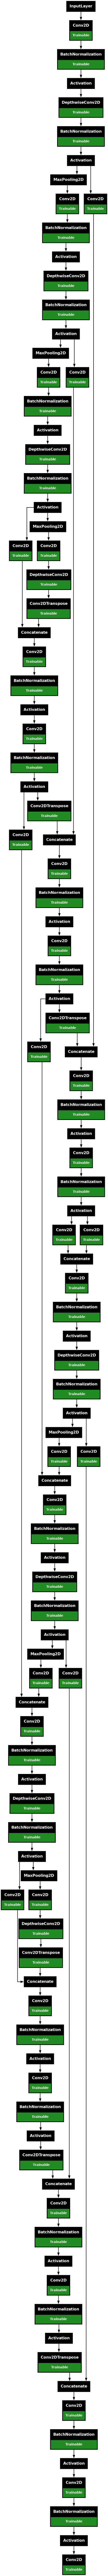

In [13]:
model = build_model()
model.summary(expand_nested=True, show_trainable=True)
tfk.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [14]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=LOSS,
    optimizer=OPTIMIZER,
    metrics=METRICS
)
print("Model compiled!")

Compiling model...
Model compiled!


# Dataset

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((img_train, msk_train))
train_dataset = train_dataset.map(lambda img, msk: (img, tf.squeeze(msk, axis=-1)), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=BATCH_SIZE * 2, seed=SEED, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((img_valid, msk_valid))
valid_dataset = valid_dataset.map(lambda img, msk: (img, tf.squeeze(msk, axis=-1)), num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.shuffle(buffer_size=BATCH_SIZE * 2, seed=SEED, reshuffle_each_iteration=False)
valid_dataset = valid_dataset.batch(BATCH_SIZE, drop_remainder=False, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Train

Epoch 1: Learning rate is 0.0010000000474974513
Epoch 1/500


I0000 00:00:1733850301.373927      68 service.cc:145] XLA service 0x7b3ff8001850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733850301.374017      68 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733850336.077171      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - loss: 0.7142 - mean_iou: 0.1757

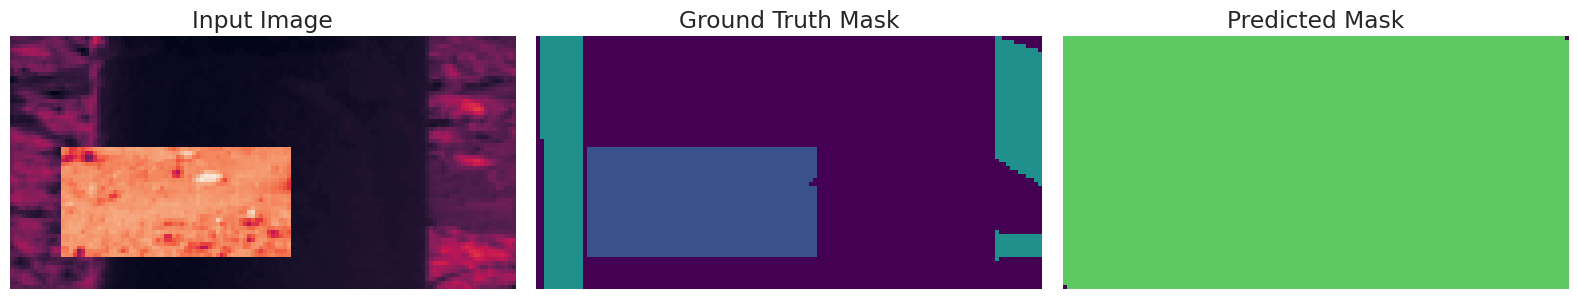

103/103 ━━━━━━━━━━━━━━━━━━━━ 154s 971ms/step - loss: 0.7138 - mean_iou: 0.1760 - val_loss: 0.8436 - val_mean_iou: 0.0496
Epoch 2: Learning rate is 0.0010000000474974513
Epoch 2/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.6525 - mean_iou: 0.2290 - val_loss: 0.8435 - val_mean_iou: 0.0496
Epoch 3: Learning rate is 0.0010000000474974513
Epoch 3/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 520ms/step - loss: 0.6460 - mean_iou: 0.2391 - val_loss: 0.8437 - val_mean_iou: 0.0496
Epoch 4: Learning rate is 0.0010000000474974513
Epoch 4/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 520ms/step - loss: 0.6410 - mean_iou: 0.2634 - val_loss: 0.8435 - val_mean_iou: 0.0499
Epoch 5: Learning rate is 0.0010000000474974513
Epoch 5/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 520ms/step - loss: 0.6245 - mean_iou: 0.3157 - val_loss: 0.7987 - val_mean_iou: 0.0944
Epoch 6: Learning rate is 0.0007000000332482159
Epoch 6/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 0.6098 - mean_iou: 0.3483

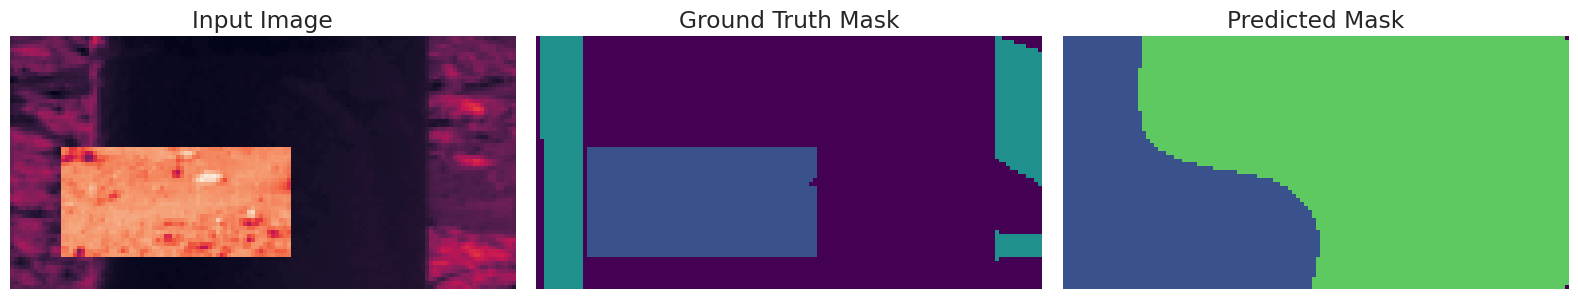

103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 525ms/step - loss: 0.6098 - mean_iou: 0.3485 - val_loss: 0.6793 - val_mean_iou: 0.2138
Epoch 7: Learning rate is 0.0007000000332482159
Epoch 7/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 520ms/step - loss: 0.6061 - mean_iou: 0.3593 - val_loss: 0.6265 - val_mean_iou: 0.3733
Epoch 8: Learning rate is 0.0007000000332482159
Epoch 8/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.6007 - mean_iou: 0.3696 - val_loss: 0.6138 - val_mean_iou: 0.3547
Epoch 9: Learning rate is 0.0007000000332482159
Epoch 9/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5950 - mean_iou: 0.3870 - val_loss: 0.6144 - val_mean_iou: 0.3126
Epoch 10: Learning rate is 0.0007000000332482159
Epoch 10/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 520ms/step - loss: 0.5919 - mean_iou: 0.3926 - val_loss: 0.5969 - val_mean_iou: 0.3857
Epoch 11: Learning rate is 0.0004900000058114529
Epoch 11/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 0.5856 - mean_iou: 0.4064

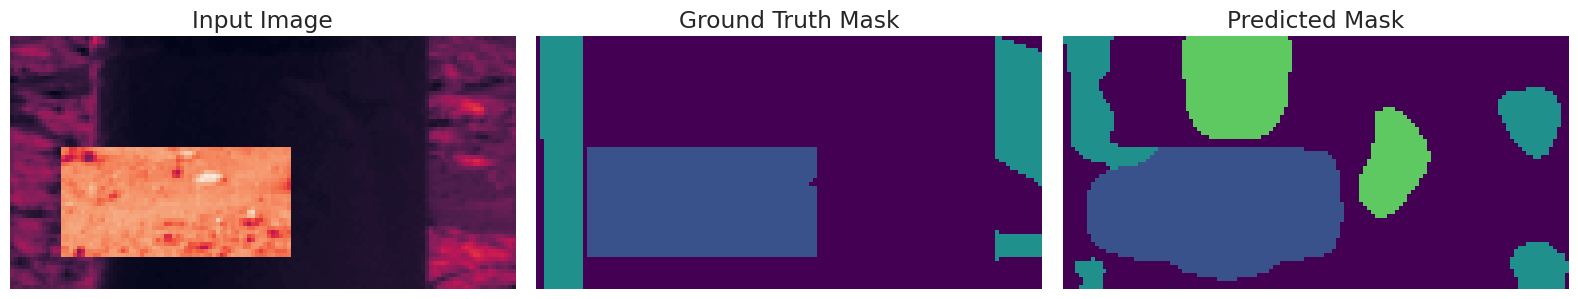

103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 527ms/step - loss: 0.5856 - mean_iou: 0.4065 - val_loss: 0.5962 - val_mean_iou: 0.3797
Epoch 12: Learning rate is 0.0004900000058114529
Epoch 12/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 520ms/step - loss: 0.5829 - mean_iou: 0.4140 - val_loss: 0.5953 - val_mean_iou: 0.3866
Epoch 13: Learning rate is 0.0004900000058114529
Epoch 13/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 520ms/step - loss: 0.5822 - mean_iou: 0.4144 - val_loss: 0.5923 - val_mean_iou: 0.3907
Epoch 14: Learning rate is 0.0004900000058114529
Epoch 14/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 520ms/step - loss: 0.5783 - mean_iou: 0.4246 - val_loss: 0.5868 - val_mean_iou: 0.4104
Epoch 15: Learning rate is 0.0004900000058114529
Epoch 15/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5742 - mean_iou: 0.4341 - val_loss: 0.6182 - val_mean_iou: 0.3224
Epoch 16: Learning rate is 0.0003430000215303153
Epoch 16/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 0.5704 - mean_iou: 0.4437

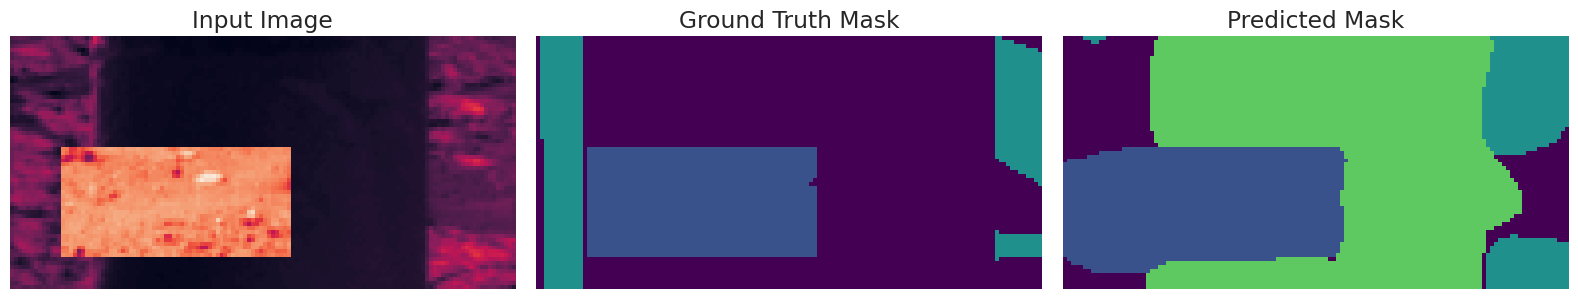

103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 525ms/step - loss: 0.5704 - mean_iou: 0.4438 - val_loss: 0.5867 - val_mean_iou: 0.4280
Epoch 17: Learning rate is 0.0003430000215303153
Epoch 17/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5678 - mean_iou: 0.4496 - val_loss: 0.5861 - val_mean_iou: 0.4211
Epoch 18: Learning rate is 0.0003430000215303153
Epoch 18/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5653 - mean_iou: 0.4553 - val_loss: 0.5889 - val_mean_iou: 0.4199
Epoch 19: Learning rate is 0.0003430000215303153
Epoch 19/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5636 - mean_iou: 0.4576 - val_loss: 0.5887 - val_mean_iou: 0.4250
Epoch 20: Learning rate is 0.0003430000215303153
Epoch 20/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 520ms/step - loss: 0.5594 - mean_iou: 0.4718 - val_loss: 0.5814 - val_mean_iou: 0.4419
Epoch 21: Learning rate is 0.0002401000092504546
Epoch 21/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 0.5583 - mean_iou: 0.4711

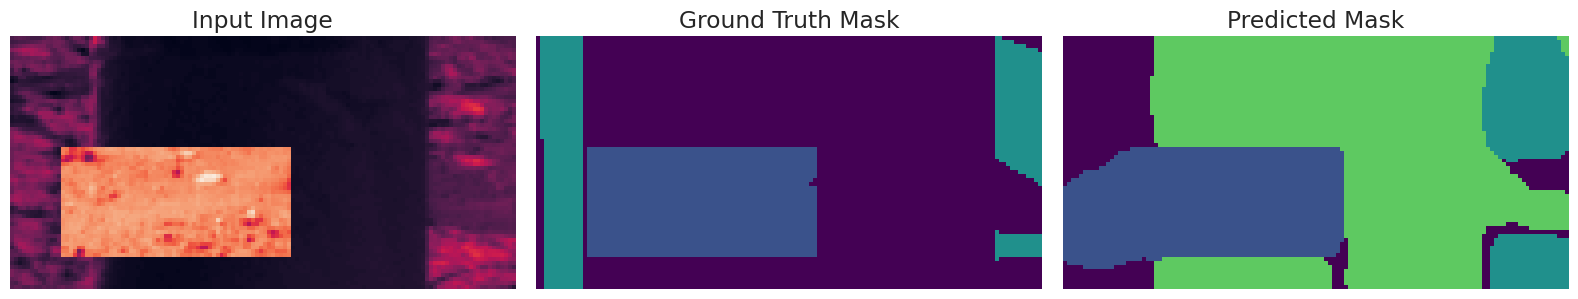

103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 525ms/step - loss: 0.5583 - mean_iou: 0.4712 - val_loss: 0.5816 - val_mean_iou: 0.4241
Epoch 22: Learning rate is 0.0002401000092504546
Epoch 22/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 520ms/step - loss: 0.5553 - mean_iou: 0.4817 - val_loss: 0.5824 - val_mean_iou: 0.4530
Epoch 23: Learning rate is 0.0002401000092504546
Epoch 23/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 520ms/step - loss: 0.5539 - mean_iou: 0.4841 - val_loss: 0.5806 - val_mean_iou: 0.4313
Epoch 24: Learning rate is 0.0002401000092504546
Epoch 24/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5522 - mean_iou: 0.4873 - val_loss: 0.5775 - val_mean_iou: 0.4375
Epoch 25: Learning rate is 0.0002401000092504546
Epoch 25/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5509 - mean_iou: 0.4932 - val_loss: 0.5863 - val_mean_iou: 0.4195
Epoch 26: Learning rate is 0.00016806999337859452
Epoch 26/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 0.5488 - mean_iou: 0.4976

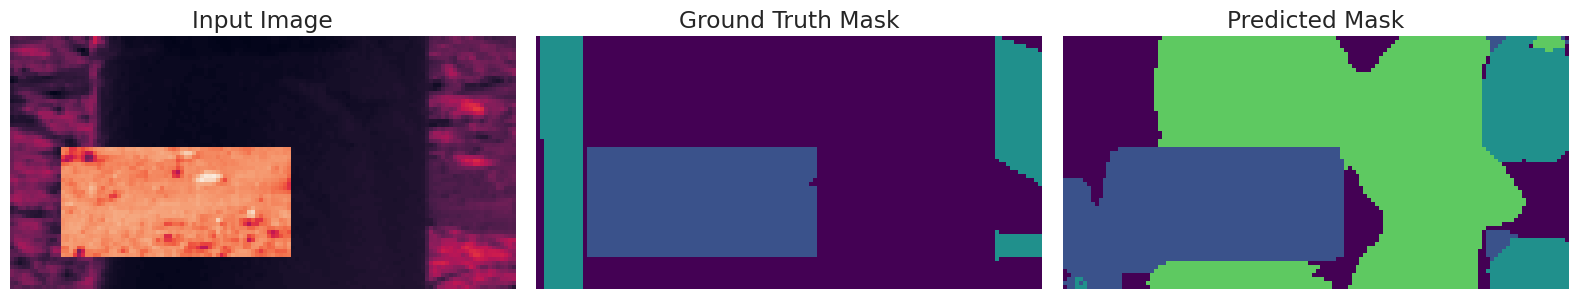

103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 524ms/step - loss: 0.5488 - mean_iou: 0.4976 - val_loss: 0.5843 - val_mean_iou: 0.4142
Epoch 27: Learning rate is 0.00016806999337859452
Epoch 27/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5474 - mean_iou: 0.4991 - val_loss: 0.5746 - val_mean_iou: 0.4437
Epoch 28: Learning rate is 0.00016806999337859452
Epoch 28/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5454 - mean_iou: 0.5064 - val_loss: 0.5749 - val_mean_iou: 0.4499
Epoch 29: Learning rate is 0.00016806999337859452
Epoch 29/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5449 - mean_iou: 0.5078 - val_loss: 0.5745 - val_mean_iou: 0.4403
Epoch 30: Learning rate is 0.00016806999337859452
Epoch 30/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5442 - mean_iou: 0.5074 - val_loss: 0.5758 - val_mean_iou: 0.4341
Epoch 31: Learning rate is 0.0001176490040961653
Epoch 31/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 0.5425 - mean_iou: 0.5142

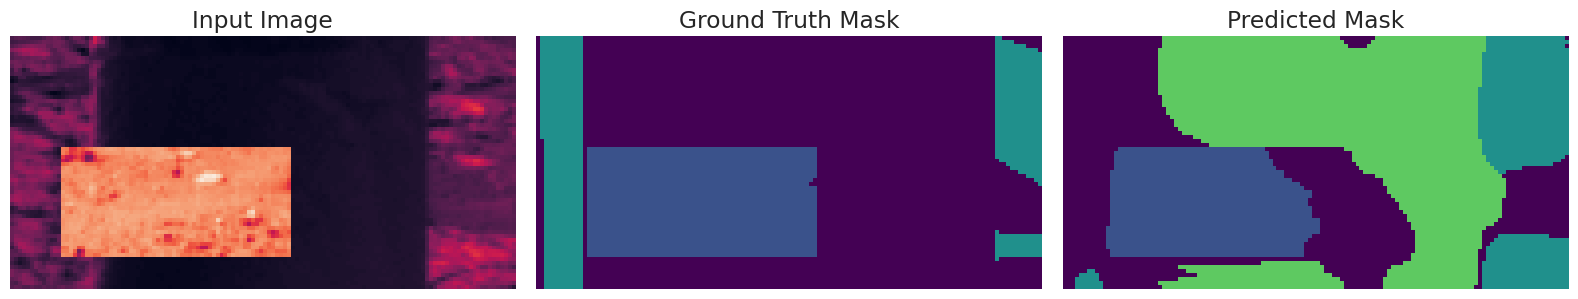

103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 524ms/step - loss: 0.5425 - mean_iou: 0.5142 - val_loss: 0.5741 - val_mean_iou: 0.4399
Epoch 32: Learning rate is 0.0001176490040961653
Epoch 32/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5418 - mean_iou: 0.5147 - val_loss: 0.5794 - val_mean_iou: 0.4170
Epoch 33: Learning rate is 0.0001176490040961653
Epoch 33/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 518ms/step - loss: 0.5409 - mean_iou: 0.5188 - val_loss: 0.5754 - val_mean_iou: 0.4365
Epoch 34: Learning rate is 0.0001176490040961653
Epoch 34/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5406 - mean_iou: 0.5170 - val_loss: 0.5801 - val_mean_iou: 0.4178
Epoch 35: Learning rate is 0.0001176490040961653
Epoch 35/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 518ms/step - loss: 0.5395 - mean_iou: 0.5226 - val_loss: 0.5719 - val_mean_iou: 0.4493
Epoch 36: Learning rate is 8.235429413616657e-05
Epoch 36/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 0.5379 - mean_iou: 0.5272

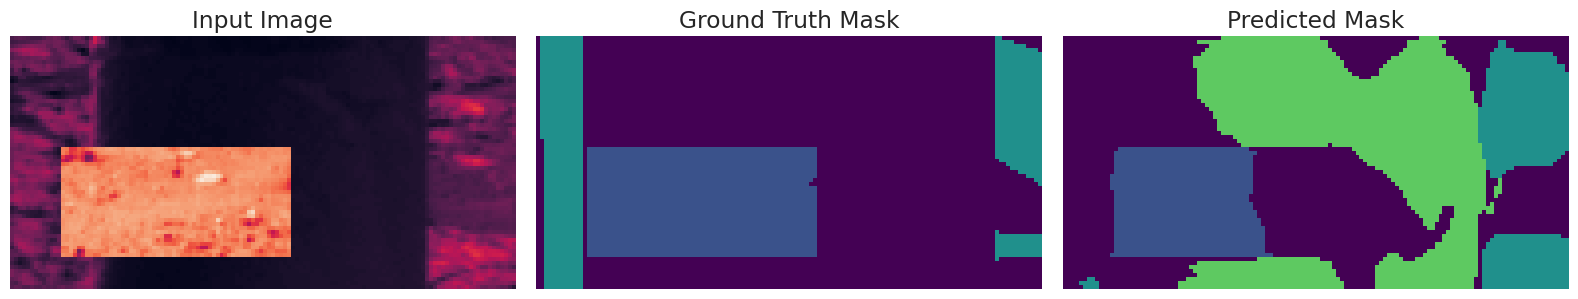

103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 523ms/step - loss: 0.5379 - mean_iou: 0.5272 - val_loss: 0.5787 - val_mean_iou: 0.4157
Epoch 37: Learning rate is 8.235429413616657e-05
Epoch 37/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 518ms/step - loss: 0.5375 - mean_iou: 0.5281 - val_loss: 0.5745 - val_mean_iou: 0.4525
Epoch 38: Learning rate is 8.235429413616657e-05
Epoch 38/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 518ms/step - loss: 0.5366 - mean_iou: 0.5303 - val_loss: 0.5786 - val_mean_iou: 0.4203
Epoch 39: Learning rate is 8.235429413616657e-05
Epoch 39/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5365 - mean_iou: 0.5292 - val_loss: 0.5743 - val_mean_iou: 0.4446
Epoch 40: Learning rate is 8.235429413616657e-05
Epoch 40/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5361 - mean_iou: 0.5316 - val_loss: 0.5749 - val_mean_iou: 0.4387
Epoch 41: Learning rate is 5.7648008805699646e-05
Epoch 41/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 0.5348 - mean_iou: 0.5339

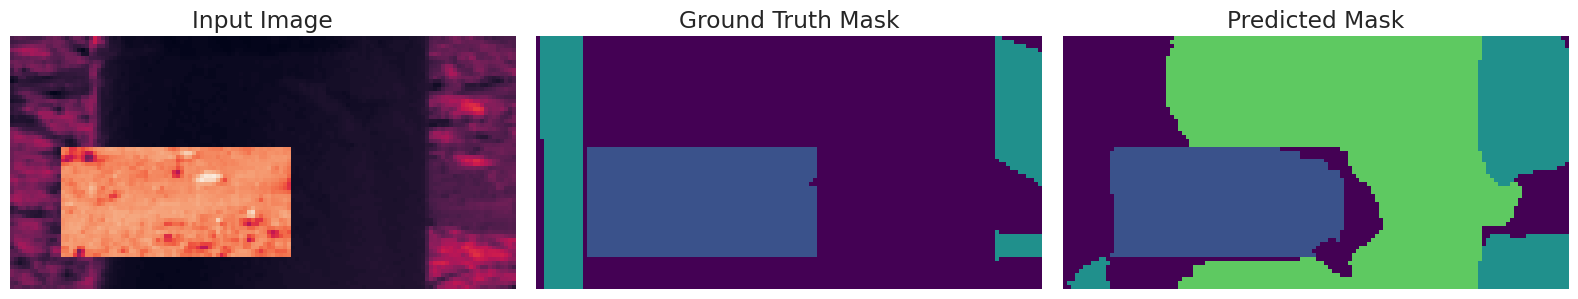

103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 524ms/step - loss: 0.5348 - mean_iou: 0.5340 - val_loss: 0.5745 - val_mean_iou: 0.4398
Epoch 42: Learning rate is 5.7648008805699646e-05
Epoch 42/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 518ms/step - loss: 0.5356 - mean_iou: 0.5302 - val_loss: 0.5747 - val_mean_iou: 0.4386
Epoch 43: Learning rate is 5.7648008805699646e-05
Epoch 43/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 518ms/step - loss: 0.5347 - mean_iou: 0.5347 - val_loss: 0.5752 - val_mean_iou: 0.4325
Epoch 44: Learning rate is 5.7648008805699646e-05
Epoch 44/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5342 - mean_iou: 0.5354 - val_loss: 0.5724 - val_mean_iou: 0.4502
Epoch 45: Learning rate is 5.7648008805699646e-05
Epoch 45/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 518ms/step - loss: 0.5337 - mean_iou: 0.5376 - val_loss: 0.5733 - val_mean_iou: 0.4428
Epoch 46: Learning rate is 4.0353606891585514e-05
Epoch 46/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 0.5335 - mean_iou: 0.5373

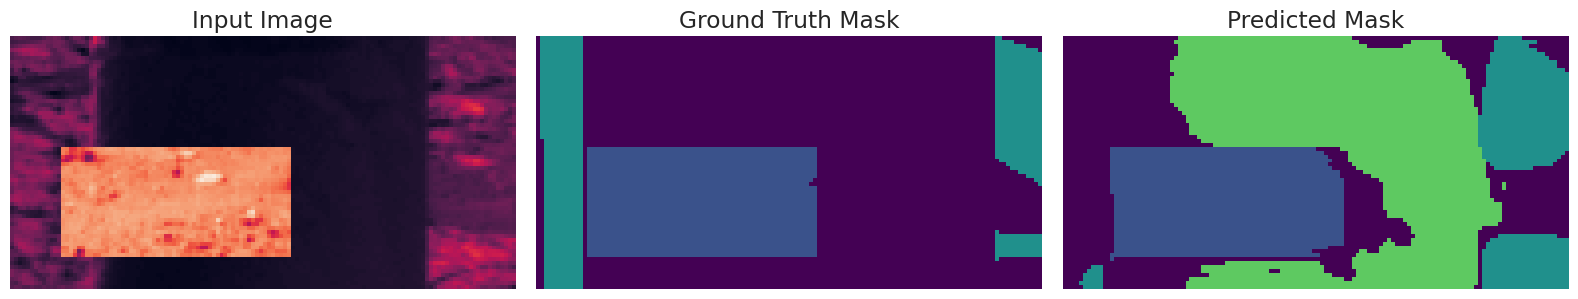

103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 523ms/step - loss: 0.5335 - mean_iou: 0.5374 - val_loss: 0.5745 - val_mean_iou: 0.4375
Epoch 47: Learning rate is 4.0353606891585514e-05
Epoch 47/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 520ms/step - loss: 0.5327 - mean_iou: 0.5398 - val_loss: 0.5722 - val_mean_iou: 0.4533
Epoch 48: Learning rate is 4.0353606891585514e-05
Epoch 48/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5330 - mean_iou: 0.5385 - val_loss: 0.5720 - val_mean_iou: 0.4469
Epoch 49: Learning rate is 4.0353606891585514e-05
Epoch 49/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5325 - mean_iou: 0.5406 - val_loss: 0.5727 - val_mean_iou: 0.4485
Epoch 50: Learning rate is 4.0353606891585514e-05
Epoch 50/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5322 - mean_iou: 0.5402 - val_loss: 0.5728 - val_mean_iou: 0.4447
Epoch 51: Learning rate is 2.8247523005120456e-05
Epoch 51/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 0.5323 - mean_iou: 0.5409

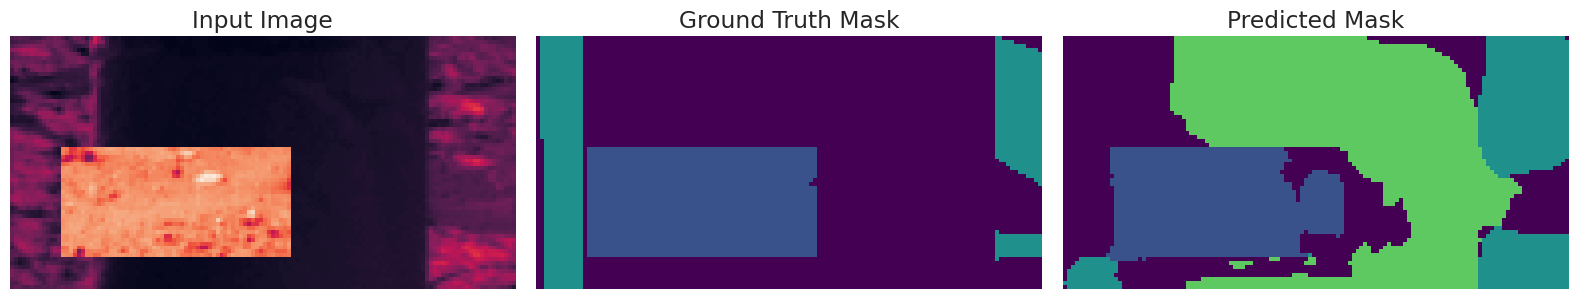

103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 523ms/step - loss: 0.5323 - mean_iou: 0.5410 - val_loss: 0.5725 - val_mean_iou: 0.4498
Epoch 52: Learning rate is 2.8247523005120456e-05
Epoch 52/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5320 - mean_iou: 0.5406 - val_loss: 0.5741 - val_mean_iou: 0.4435
Epoch 53: Learning rate is 2.8247523005120456e-05
Epoch 53/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5318 - mean_iou: 0.5421 - val_loss: 0.5729 - val_mean_iou: 0.4476
Epoch 54: Learning rate is 2.8247523005120456e-05
Epoch 54/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 518ms/step - loss: 0.5314 - mean_iou: 0.5426 - val_loss: 0.5733 - val_mean_iou: 0.4420
Epoch 55: Learning rate is 2.8247523005120456e-05
Epoch 55/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 518ms/step - loss: 0.5313 - mean_iou: 0.5431 - val_loss: 0.5724 - val_mean_iou: 0.4471
Epoch 56: Learning rate is 1.977326610358432e-05
Epoch 56/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 0.5313 - mean_iou: 0.5429

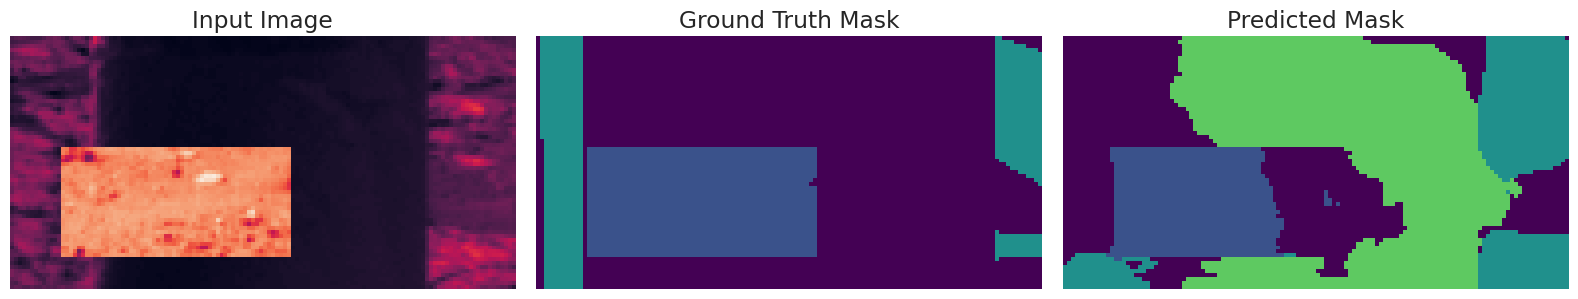

103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 523ms/step - loss: 0.5313 - mean_iou: 0.5430 - val_loss: 0.5725 - val_mean_iou: 0.4498
Epoch 57: Learning rate is 1.977326610358432e-05
Epoch 57/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5311 - mean_iou: 0.5437 - val_loss: 0.5722 - val_mean_iou: 0.4498
Epoch 58: Learning rate is 1.977326610358432e-05
Epoch 58/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 518ms/step - loss: 0.5313 - mean_iou: 0.5428 - val_loss: 0.5723 - val_mean_iou: 0.4524
Epoch 59: Learning rate is 1.977326610358432e-05
Epoch 59/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5309 - mean_iou: 0.5437 - val_loss: 0.5728 - val_mean_iou: 0.4471
Epoch 60: Learning rate is 1.977326610358432e-05
Epoch 60/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5307 - mean_iou: 0.5443 - val_loss: 0.5718 - val_mean_iou: 0.4517
Epoch 61: Learning rate is 1.3841286090610083e-05
Epoch 61/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 0.5306 - mean_iou: 0.5445

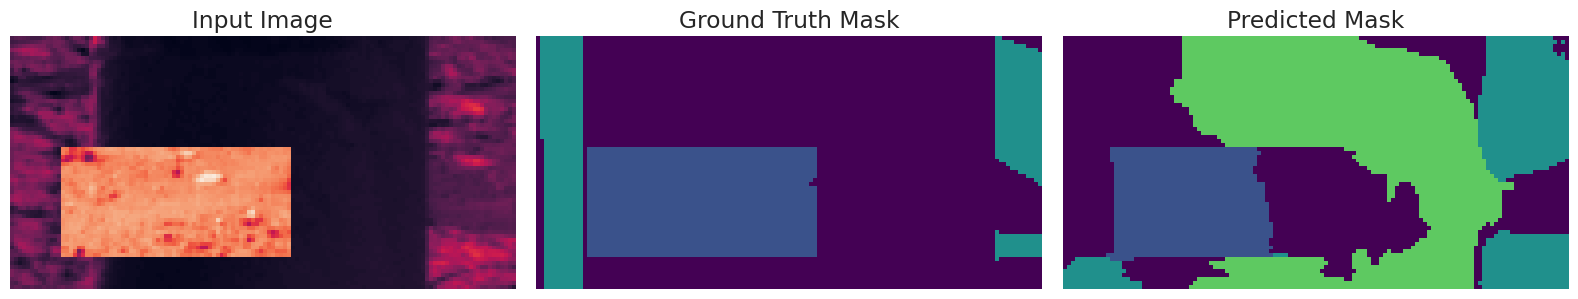

103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 525ms/step - loss: 0.5306 - mean_iou: 0.5445 - val_loss: 0.5726 - val_mean_iou: 0.4457
Epoch 62: Learning rate is 1.3841286090610083e-05
Epoch 62/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 518ms/step - loss: 0.5305 - mean_iou: 0.5450 - val_loss: 0.5730 - val_mean_iou: 0.4472
Epoch 63: Learning rate is 1.3841286090610083e-05
Epoch 63/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 518ms/step - loss: 0.5303 - mean_iou: 0.5453 - val_loss: 0.5729 - val_mean_iou: 0.4470
Epoch 64: Learning rate is 1.3841286090610083e-05
Epoch 64/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 518ms/step - loss: 0.5303 - mean_iou: 0.5460 - val_loss: 0.5726 - val_mean_iou: 0.4468
Epoch 65: Learning rate is 1.3841286090610083e-05
Epoch 65/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 518ms/step - loss: 0.5302 - mean_iou: 0.5449 - val_loss: 0.5726 - val_mean_iou: 0.4485
Epoch 66: Learning rate is 9.688900718174409e-06
Epoch 66/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 0.5301 - mean_iou: 0.5458

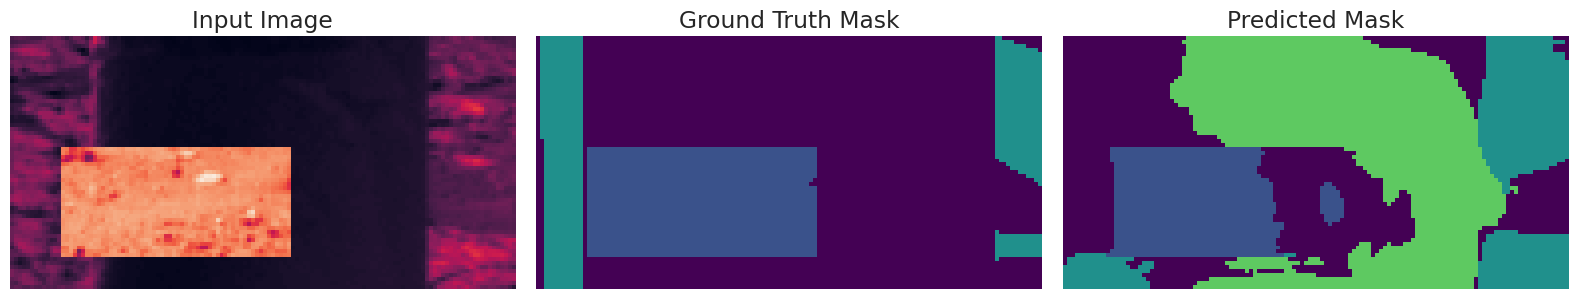

103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 523ms/step - loss: 0.5301 - mean_iou: 0.5458 - val_loss: 0.5732 - val_mean_iou: 0.4456
Epoch 67: Learning rate is 9.688900718174409e-06
Epoch 67/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5300 - mean_iou: 0.5461 - val_loss: 0.5730 - val_mean_iou: 0.4457
Epoch 68: Learning rate is 9.688900718174409e-06
Epoch 68/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5298 - mean_iou: 0.5462 - val_loss: 0.5733 - val_mean_iou: 0.4455
Epoch 69: Learning rate is 9.688900718174409e-06
Epoch 69/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 520ms/step - loss: 0.5298 - mean_iou: 0.5463 - val_loss: 0.5736 - val_mean_iou: 0.4433
Epoch 70: Learning rate is 9.688900718174409e-06
Epoch 70/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 520ms/step - loss: 0.5297 - mean_iou: 0.5467 - val_loss: 0.5736 - val_mean_iou: 0.4424
Epoch 71: Learning rate is 6.782229775126325e-06
Epoch 71/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 0.5299 - mean_iou: 0.5463

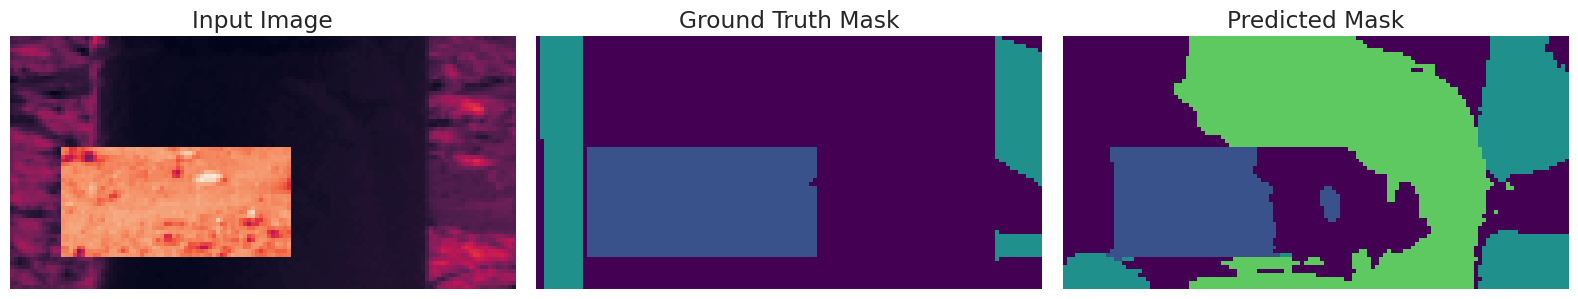

103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 524ms/step - loss: 0.5299 - mean_iou: 0.5463 - val_loss: 0.5736 - val_mean_iou: 0.4422
Epoch 72: Learning rate is 6.782229775126325e-06
Epoch 72/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 520ms/step - loss: 0.5299 - mean_iou: 0.5459 - val_loss: 0.5728 - val_mean_iou: 0.4465
Epoch 73: Learning rate is 6.782229775126325e-06
Epoch 73/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 520ms/step - loss: 0.5298 - mean_iou: 0.5469 - val_loss: 0.5730 - val_mean_iou: 0.4465
Epoch 74: Learning rate is 6.782229775126325e-06
Epoch 74/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5294 - mean_iou: 0.5474 - val_loss: 0.5734 - val_mean_iou: 0.4448
Epoch 75: Learning rate is 6.782229775126325e-06
Epoch 75/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 519ms/step - loss: 0.5296 - mean_iou: 0.5473 - val_loss: 0.5735 - val_mean_iou: 0.4423
Epoch 76: Learning rate is 4.747560979012633e-06
Epoch 76/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 0.5296 - mean_iou: 0.5472

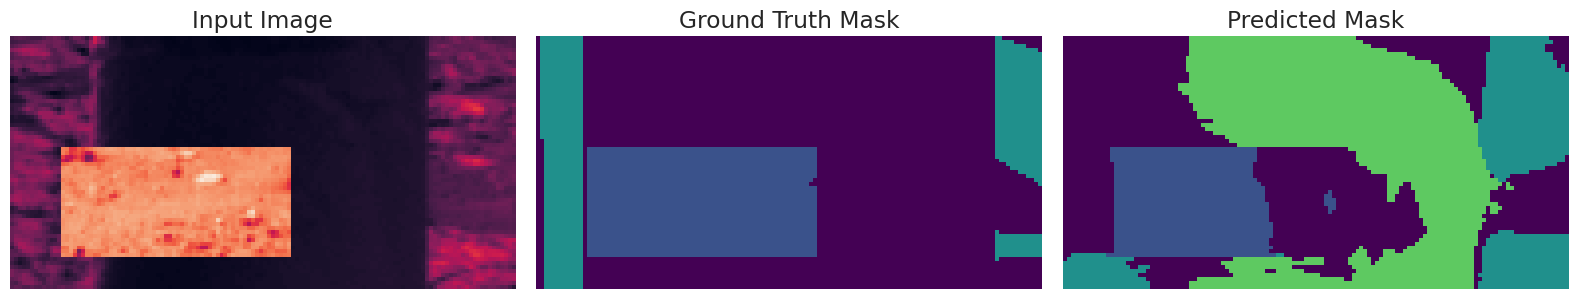

103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 522ms/step - loss: 0.5296 - mean_iou: 0.5473 - val_loss: 0.5736 - val_mean_iou: 0.4421
Epoch 77: Learning rate is 4.747560979012633e-06
Epoch 77/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 518ms/step - loss: 0.5297 - mean_iou: 0.5463 - val_loss: 0.5734 - val_mean_iou: 0.4436
Final validation Mean Intersection Over Union: 45.33%


In [16]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=CALLBACKS
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
MODEL_FILENAME = 'weigths.keras'
model.save(MODEL_FILENAME)

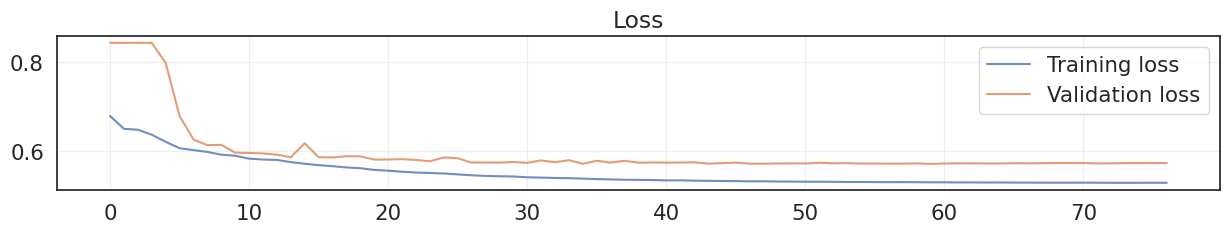

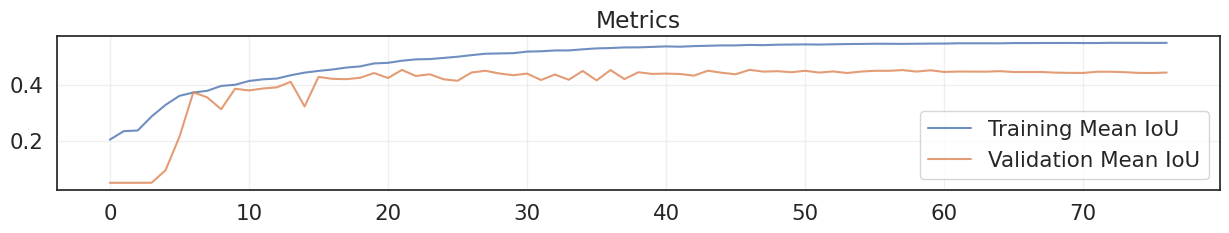

In [17]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation metric
plt.figure(figsize=(15, 2))
plt.plot(history['mean_iou'], label='Training Mean IoU', alpha=.8)
plt.plot(history['val_mean_iou'], label='Validation Mean IoU', alpha=.8)
plt.title('Metrics')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# Make predictions

In [18]:
import gc

del model
gc.collect()

132267

In [19]:
model = tfk.models.load_model(MODEL_FILENAME)
print(f"Model loaded from {MODEL_FILENAME}")

Model loaded from weigths.keras


In [20]:
preds = model.predict(img_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step
Predictions shape: (10022, 64, 128)


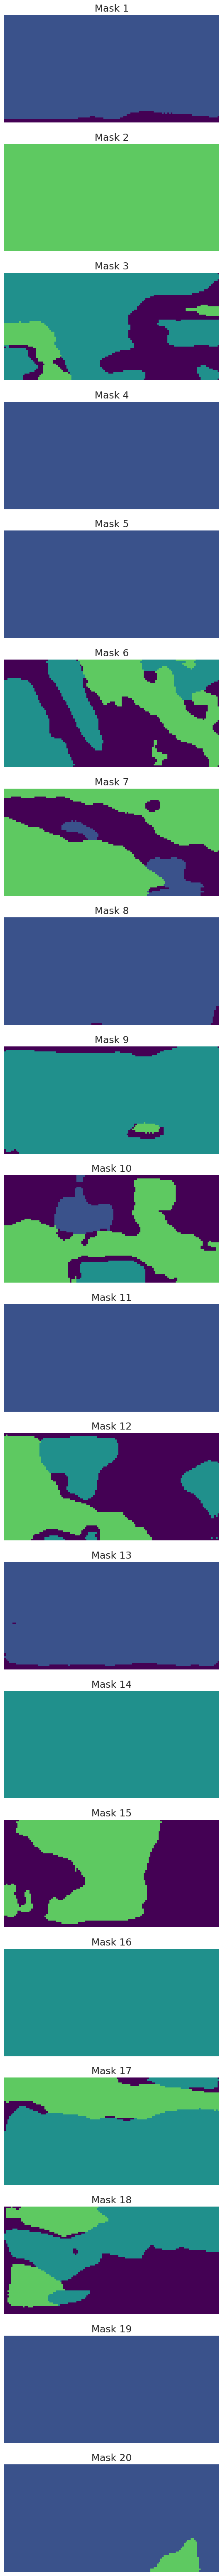

In [21]:
num_samples=20
colormap = create_segmentation_colormap(NUM_CLASSES)
plt.figure(figsize=(15, 4*num_samples))
for i in range(num_samples):
    plt.subplot(num_samples, 1, i+1)
    colored_label = apply_colormap(preds[i], colormap)
    plt.imshow(colored_label)
    plt.title(f'Mask {i+1}')
    plt.axis('off')

In [22]:
import pandas as pd

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [23]:
from datetime import datetime

# Create and download the csv submission file
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
SUBMISSION_FILENAME = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(SUBMISSION_FILENAME, index=False)